## Object Detection with OpenCV-Python using YOLOv3

In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Problem Statement: 

    Object detection in the image/video captured by the front camera of the self driving car.

### Import required libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imageio
import os

In [4]:

os.chdir('/content/drive/MyDrive/Colab Notebooks/CV_spec/computer_vision-dev/ObjectDetection/YOLOv3')

### YOLO — You Only Look Once
    
Is an extremely fast multi object detection algorithm which uses convolutional neural network (CNN) to detect and identify objects.

![YOLOv3](yolov3.jpg)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold 
nmsThreshold = 0.4   # Non-maximum suppression threshold
blobWidth = 416       # Width of network's input image
blobHeight = 416      # Height of network's input image

### Load the YOLOv3
    
* Use [cv2.dnn.readNet](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga3b34fe7a29494a6a4295c169a7d32422) to load YOLOv3 pretrained model by giving configuration and weight files

    * The pre-trained [YOLO weight file](https://pjreddie.com/media/files/yolov3.weights) (237 MB) trained on coco dataset. 

    * The [YOLO configuration file](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/10e685aad953495a95c17bfecd1649e5/yolov3.cfg).
    
Note: We will be using YoloV3 pretrained model from [darknet.Darknet](https://pjreddie.com/darknet/)

In [20]:
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

The YOLO neural network has 254 components. 

In [21]:
layer_names = net.getLayerNames()

print(len(layer_names))

print(layer_names)

254
['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38',

#### Output layers

* Use __getUnconnectedOutLayers()__ function to get the indexes of layers with unconnected outputs.

In [22]:
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

### Load the COCO labels/class name

* From [coco.names](https://opencv-tutorial.readthedocs.io/en/latest/_downloads/a9fb13cbea0745f3d11da9017d1b8467/coco.names) file
* [COCO](http://cocodataset.org/#home) is a large-scale object detection, segmentation, and captioning dataset. It has 80 object categories and around 1.5 million object instances
![COCO](img/coco.jpg)

In [23]:
# Load names of classes and get random colors
classes = open('coco.names').read().strip().split('\n')

In [24]:
print(len(classes))
print(classes)

80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [25]:
np.random.seed(42)

colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

colors.shape

(80, 3)

### Load the Image captured from the car's front view camera

In [26]:
img = cv2.imread("Images/front1.jpg")

img_height, img_width, img_channels = img.shape

print(img_height, img_width, img_channels)

345 602 3


### Display the Image

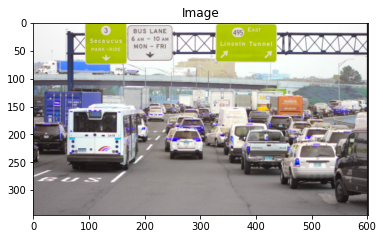

In [27]:
plt.imshow(img)
plt.title('Image')
plt.show()

### Creat a blob from Image 

* The input to the network is a so-called blob object. 
* A blob is a 4D numpy array object (images, channels, width, height). 
* The function __cv.dnn.blobFromImage()__ transforms the image into a blob.    
    * The image to transform
    * The scale factor (1/255 to scale the pixel values to [0..1])
    * The size, here a 416x416 square image
    * The mean value (default=0)
    * The option swapBR=True (since OpenCV uses BGR)

In [28]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1/255.0, 
                             size=(blobWidth, blobHeight), mean=(0, 0, 0),
                             swapRB=True, crop=False)
blob.shape

(1, 3, 416, 416)

### Identifiy objects

    These two instructions calculate the network response:

In [29]:
net.setInput(blob)

outputs = net.forward(output_layers)

In [31]:
print (len(outputs))

for output in outputs:
    print(output.shape)

3
(507, 85)
(2028, 85)
(8112, 85)


In [ ]:
#{pc,x,y,w,h,c1,c2,...c80}

In [32]:
507+2028+8112

10647

#### The YOLO network has 3 outputs:

    507 (13 x 13 x 3) for large objects   - Layer 82
    2028 (26 x 26 x 3) for medium objects - Layer 94
    8112 (52 x 52 x 3) for small objects  - Layer 106
 
#### The outputs object are vectors of lenght 85
  
* 4 the bounding box (centerx, centery, width, height)
* 1 box confidence
* 80 class confidence


### Function to get bounding box co-ordinates, confidence score and class labels. 
    
    Write a function that take out of the network as input and return box co-ordinates, confidence score and class labels as output

In [33]:
def get_boxes(net_output, confThreshold):
    
    boxes       = []          
    class_ids   = []
    confidences = []

    for detection in net_output:
        # Get the probability score and bounding box co-ordinates for each cell
        # Get the Class scores
        scores     = detection[5:] #{pc,x,y,w,h,c1,c2,c3,....c80}
        class_id   = np.argmax(scores)
        confidence = scores[class_id]
        
        # If the max class score is greater then confThreshold get the co-ordinates
        if confidence > confThreshold:
            center_x = int(detection[0] * img_width)
            center_y = int(detection[1] * img_height)
            
            width  = int(detection[2] * img_width)
            height = int(detection[3] * img_height)
            
            x = int(center_x - width/2)
            y = int(center_y - height/2)
            
            # Store bounding box's (x, y, width and height), confidence and class_id
            boxes.append([x, y, width, height])
            class_ids.append(class_id)
            confidences.append(float(confidence))
            
    return boxes, class_ids, confidences

### Function to embedded detected object using the bounding box 

In [36]:
'''
This function draws the bounding boxes along with the label.
Input: boxes, nms filtered indexes, nms boolean value
Output: Image highlighted with the bounding boxes, labels 

'''
def embed_boxes(image, boxes, class_ids, confidences):
        
    image = image.copy()
    
    for (box, class_id, confidence) in zip(boxes, class_ids, confidences):

        x, y, width, height  = box
        
        color = [int(c) for c in colors[class_id]]
    
        # Syntax: cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)
        
        text = "{}: {:.4f}".format(classes[class_id], confidence)      
        # Syntax: cv2.putText(image, text, org, font, fontScale, color[, thickness[,
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return image

def display_image(image):
    plt.imshow(image)
    plt.show()

### Bounding box, class_ids and conf from 82nd layer

In [37]:
boxes, class_ids, confidences = get_boxes(outputs[0], 0.2)

### Display bounding box before non-max supression

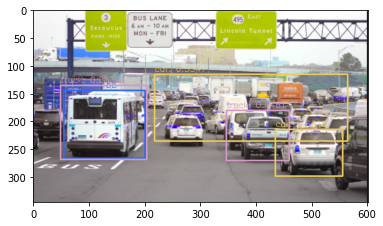

In [38]:
image = embed_boxes(img, boxes, class_ids, confidences)
display_image(image)

### Apply non-max supression

Non-Max Supression is a popular computer vision technique to remove the overlapping boxes for the same object

__NMSBoxes(bboxes, scores, score_threshold, nms_threshold) -> indices__
    * bboxes a set of bounding boxes to apply NMS.
    * scores a set of corresponding confidences.
    * score_threshold a threshold used to filter boxes by score.
    * nms_threshold a threshold used in non maximum suppression.
 
Returns the indices the kept indices of bboxes after NMS.

In [40]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
print(indices)

[[1]
 [4]]


### Display bounding box after non-max supression

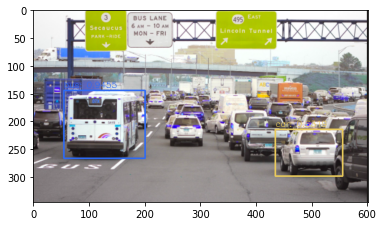

In [25]:
if len(indices) > 0:
    nms_boxes = [boxes[i] for i in indices.flatten()]
    nms_class_ids = [class_ids[i] for i in indices.flatten()]
    nms_confidences = [confidences[i] for i in indices.flatten()]
    
    image = embed_boxes(img, nms_boxes, nms_class_ids, nms_confidences)
    
    display_image(image)

### Bounding box, class_ids and conf from 94nd layer

In [41]:
boxes, class_ids, confidences = get_boxes(outputs[1], 0.2)

### Display bounding box before non-max supression

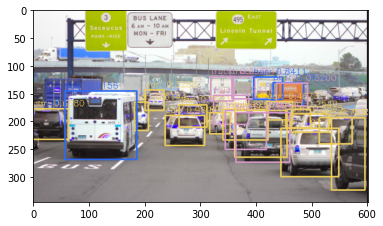

In [42]:
image = embed_boxes(img, boxes, class_ids, confidences)
display_image(image)

### Apply non-max supression

In [28]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
print(indices)

[[16]
 [21]
 [22]
 [12]
 [20]
 [ 2]
 [14]
 [13]
 [ 3]
 [19]
 [ 9]
 [11]
 [ 8]]


### Display bounding box after non-max supression

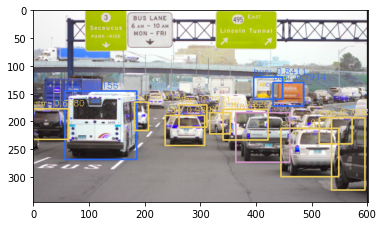

In [29]:
if len(indices) > 0:
    nms_boxes = [boxes[i] for i in indices.flatten()]
    nms_class_ids = [class_ids[i] for i in indices.flatten()]
    nms_confidences = [confidences[i] for i in indices.flatten()]
    
    image = embed_boxes(img, nms_boxes, nms_class_ids, nms_confidences)
    
    display_image(image)

### Bounding box, class_ids and conf from 106nd layer

In [30]:
boxes, class_ids, confidences = get_boxes(outputs[2], 0.2)

### Display bounding box before non-max supression

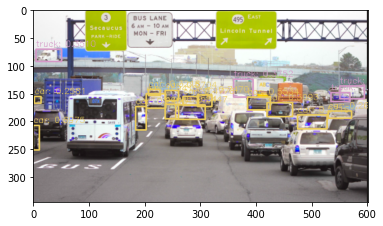

In [31]:
image = embed_boxes(img, boxes, class_ids, confidences)
display_image(image)

### Apply non-max supression

In [32]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
print(indices)

[[ 7]
 [ 9]
 [17]
 [ 3]
 [16]
 [ 4]
 [10]
 [13]]


### Display bounding box after non-max supression

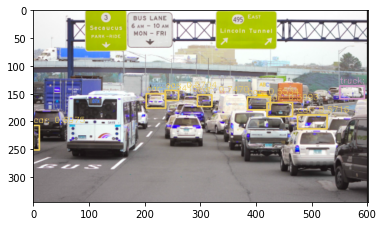

In [33]:
if len(indices) > 0:
    nms_boxes = [boxes[i] for i in indices.flatten()]
    nms_class_ids = [class_ids[i] for i in indices.flatten()]
    nms_confidences = [confidences[i] for i in indices.flatten()]
    
    image = embed_boxes(img, nms_boxes, nms_class_ids, nms_confidences)
    
    display_image(image)

### Bounding box, class_ids and conf from 82, 94 and 106 layers

#### Combine the 3 output groups into 1 (10647, 85)
    * large objects (507, 85)
    * medium objects (2028, 85)
    * small objects (8112, 85)

In [34]:
print(len(outputs))
print(len(outputs[0]))
print(len(outputs[1]))
print(len(outputs[2]))

3
507
2028
8112


In [35]:
outputs = np.vstack(outputs)

In [36]:
print(len(outputs))

10647


In [37]:
boxes, class_ids, confidences = get_boxes(outputs, 0.2)

### Display bounding box before non-max supression

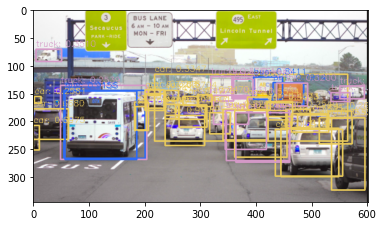

In [38]:
image = embed_boxes(img, boxes, class_ids, confidences)
display_image(image)

### Apply non-max supression

In [39]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
print(indices)

[[21]
 [26]
 [27]
 [ 1]
 [35]
 [25]
 [ 7]
 [19]
 [18]
 [ 8]
 [24]
 [14]
 [37]
 [45]
 [16]
 [31]
 [44]
 [32]
 [38]
 [13]
 [41]]


### Display bounding box after non-max supression

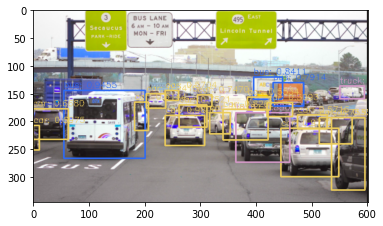

In [40]:
if len(indices) > 0:
    nms_boxes = [boxes[i] for i in indices.flatten()]
    nms_class_ids = [class_ids[i] for i in indices.flatten()]
    nms_confidences = [confidences[i] for i in indices.flatten()]
    
    image = embed_boxes(img, nms_boxes, nms_class_ids, nms_confidences)
    
    display_image(image)

## Create a function having all the code together

In [41]:
'''
This function detects the objects in the frame and draws the bounding boxes with the class labels and class scores 
Input: Frame of the video
Output: Frame highlighted with the bounding boxes, labels and scores

'''
def detect_objects(frame):
    
    #Convert the image/frame to an blob
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1/255.0, 
                                 size=(blobWidth, blobHeight), mean=(0, 0, 0),
                                 swapRB=True, crop=False)

    #Set the blob as Input to the network
    net.setInput(blob)
    # Get the output from the network
    outputs = net.forward(output_layers)
    
    # Combine the 3 output groups into 1
    # Stack arrays in sequence vertically (row wise).
    outputs = np.vstack(outputs)

    boxes, class_ids, confidences = get_boxes(outputs, confThreshold)
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    if len(indices) > 0:
        nms_boxes = [boxes[i] for i in indices.flatten()]
        nms_class_ids = [class_ids[i] for i in indices.flatten()]
        nms_confidences = [confidences[i] for i in indices.flatten()]
    
        embed_frame = embed_boxes(frame, nms_boxes, nms_class_ids, nms_confidences)
    
        return embed_frame
    else:
        return frame


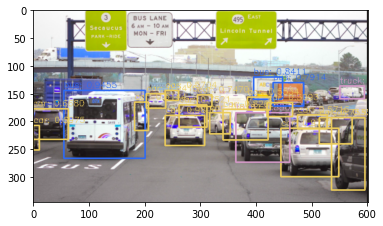

In [42]:
image = detect_objects(img)
display_image(image)

## Detect the objects in self driving car video

### Define the Input Video and Output video path 

In [43]:
output_video_path = 'output_video'
input_video_path = 'input_video'

### Extract each frame of the video , detect the objects and append the frames to video writer 

In [ ]:
# For each Video in the path
for file in os.listdir(input_video_path):
    name, ext = os.path.splitext(file)
    if ext == '.mp4':
        # Create a video reader
        video_reader = imageio.get_reader(os.path.join(input_video_path, file))
        fps = video_reader.get_meta_data()['fps'] # get fps of the image
        # Create a video writer
        video_writer = imageio.get_writer(os.path.join(output_video_path, file), fps = fps) 
        # Iterate over frames in a video
        for i, frame in enumerate(video_reader):
            detected_frame = detect_objects(frame)
            video_writer.append_data(detected_frame) # appending frame to video
            print('frame ', i, 'done')
        #close the video reader and writer
        video_reader.close()
        video_writer.close()

frame  0 done
frame  1 done
frame  2 done
frame  3 done
frame  4 done
frame  5 done
frame  6 done
frame  7 done
frame  8 done
frame  9 done
frame  10 done
frame  11 done
frame  12 done
frame  13 done
frame  14 done
frame  15 done
frame  16 done
frame  17 done
frame  18 done
frame  19 done
frame  20 done
frame  21 done
frame  22 done
frame  23 done
frame  24 done
frame  25 done
frame  26 done
frame  27 done
frame  28 done
frame  29 done
frame  30 done
frame  31 done
frame  32 done
frame  33 done
frame  34 done
frame  35 done
frame  36 done
frame  37 done
frame  38 done
frame  39 done
frame  40 done
frame  41 done
frame  42 done
frame  43 done
frame  44 done
frame  45 done
frame  46 done
frame  47 done
frame  48 done
frame  49 done
frame  50 done
frame  51 done
frame  52 done
frame  53 done
frame  54 done
frame  55 done
frame  56 done
frame  57 done
frame  58 done
frame  59 done
frame  60 done
frame  61 done
frame  62 done
frame  63 done
frame  64 done
frame  65 done
frame  66 done
frame

##### Ref: 

https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html